In [ ]:
from airflow import DAG
from datetime import timedelta, datetime
from airflow.providers.http.sensors.http import HttpSensor
import json
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
import pandas as pd

In [2]:
from IPython.display import Image
%matplotlib inline

In [ ]:
# Transformacion de grados kelvin a grados centigrados
# Transformation from kelvin to celsious

def kelvin_a_Celcios(temp_in_kelvin):
    temp_en_Celcious = (temp_in_kelvin - 273.15)
    return round(temp_en_Celcious, 2)

In [ ]:
# Generacion de funcion para extraer las diferentes etiquetas que estan en formato JSON.
# Function transformation to get lables from JSON file

def transformar_datos_carga(task_instance):
    datos = task_instance.xcom_pull(task_ids="extract_weather_data")
    Ciudad = datos["name"]
    Descripcion = datos["weather"][0]['description']
    temperatura = kelvin_a_Celcios(datos["main"]["temp"])
    sensacion = kelvin_a_Celcios(datos["main"]["feels_like"])
    min_temp_celcios = kelvin_a_Celcios(datos["main"]["temp_min"])
    max_temp_celcios = kelvin_a_Celcios(datos["main"]["temp_max"])
    presion = datos["main"]["pressure"]
    humedad = datos["main"]["humidity"]
    velocidad_vi = datos["wind"]["speed"]
    hora = datetime.utcfromtimestamp(datos['dt'] + datos['timezone'])
    amanecer = datetime.utcfromtimestamp(datos['sys']['sunrise'] + datos['timezone'])
    atardecer = datetime.utcfromtimestamp(datos['sys']['sunset'] + datos['timezone'])

In [ ]:
# Generacion de diccionario con las key-value necesarios para generar un dataframe
# Dictionary generation with all necessary key-value pairs to get dataframe.

datos_transformados = {"Nombre_Ciudad": Ciudad,
            "Descripcion del clima": Descripcion,
            "Temperatura en Celcios (C)": temperatura,
            "Sensacion Termica en C": sensacion,
            "Temperatura minima en C": min_temp_celcios,
            "Temperatura maxima en C": max_temp_celcios,
            "Presion Atmosferica": presion,
            "Humedad": humedad,
            "Velocidad del tiempo": velocidad_vi,
            "Fecha y hora de recollecion del dato": hora,
            "Amanecer (Hora Local)": amanecer,
            "Atardecer (Hora Local)": atardecer                      
            }

In [ ]:
# Generacion de los formatos y credenciales necesarios para la data tranformada y carga de datos en dispositorios finales
# Necessary Format and credentials generation to load transformed data into final repositories 

datos_transformados_lista = [datos_transformados]
df_datos = pd.DataFrame(datos_transformados_lista)
Tiempo_actual = datetime.now()
dt_string = Tiempo_actual.strftime("%d%m%Y%H%M%S")
dt_string = 'Reporte_del_tiempo_para_Cuenca_Ecuador' + dt_string
df_datos.to_csv(f"{dt_string}.csv", index=False)  ## Datos guardados en instancia en EC2.


datos_transformados_lista = [datos_transformados]
df_datos = pd.DataFrame(datos_transformados_lista)
credenciales_aws = {'key': 'xxxxxxxxxxx', 'secret':  'xxxxxx', 
                    "token": 'xxxxxxx'} ## Credenciales obtenidas desde cuenta en amazon con el siguiente comando: aws sts get-session-token
Tiempo_actual = datetime.now()
dt_string = Tiempo_actual.strftime("%d%m%Y%H%M%S")
dt_string = 'Reporte_del_tiempo_para_Cuenca_Ecuador' + dt_string
df_datos.to_csv(f"s3://cuenca-etl/{dt_string}.csv", index=False, storage_options=credenciales_aws)  ## Datos guardados en instancia en EC2.

In [ ]:
# Generacion de argumentos para pasarlos a la funcion dag que se encargara de realiar el proceso de Extraccion, Transformacion y Carga.
# Generation of arguments to pass them to the dag function that will be responsible for carrying out the Extraction, Transformation and Loading process (ETL)

args_defecto = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 4, 8),
    'email': ['xavico901899@gmail.com'],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=2)}

In [ ]:
# DAG para ETL
with DAG('weather_dag',
        default_args=args_defecto,
        schedule_interval = '@daily',
        catchup=False) as dag:


        is_weather_api_ready = HttpSensor(
        task_id ='is_weather_api_ready',
        http_conn_id='weathermap_api',
        endpoint='data/2.5/weather?q=Cuenca,%20EC&APPID=xxxxx' # El APPIID se obtiene de la cuenta en https://openweathermap.org/current
        )

        extract_weather_data = SimpleHttpOperator(
        task_id = 'extract_weather_data',
        http_conn_id = 'weathermap_api',
        endpoint='data/2.5/weather?q=Cuenca,%20EC&APPID=xxxx', # El APPIID se obtiene de la cuenta en https://openweathermap.org/current
        method = 'GET',
        response_filter= lambda r: json.loads(r.text),
        log_response=True) 

        transform_load_weather_data = PythonOperator(
        task_id= 'transform_load_weather_data',
        python_callable=transformar_datos_carga)

        is_weather_api_ready >> extract_weather_data >> transform_load_weather_data

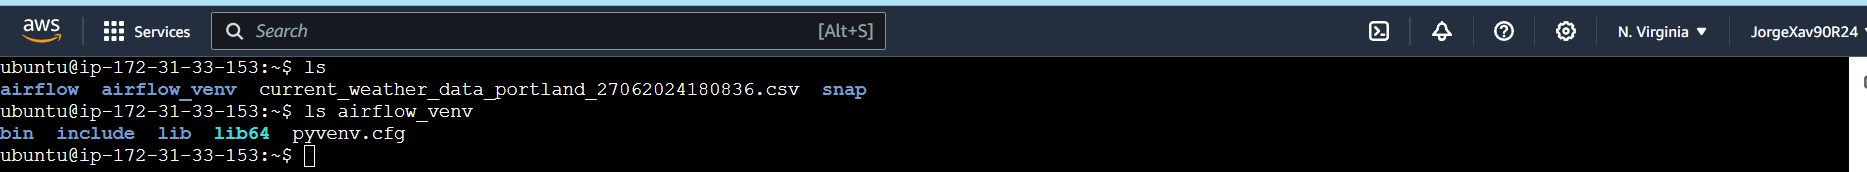

In [6]:
# Instancia airflow en aws ec2 ubuntu
Image(filename='Airflow_Instance.png', width=5000) 

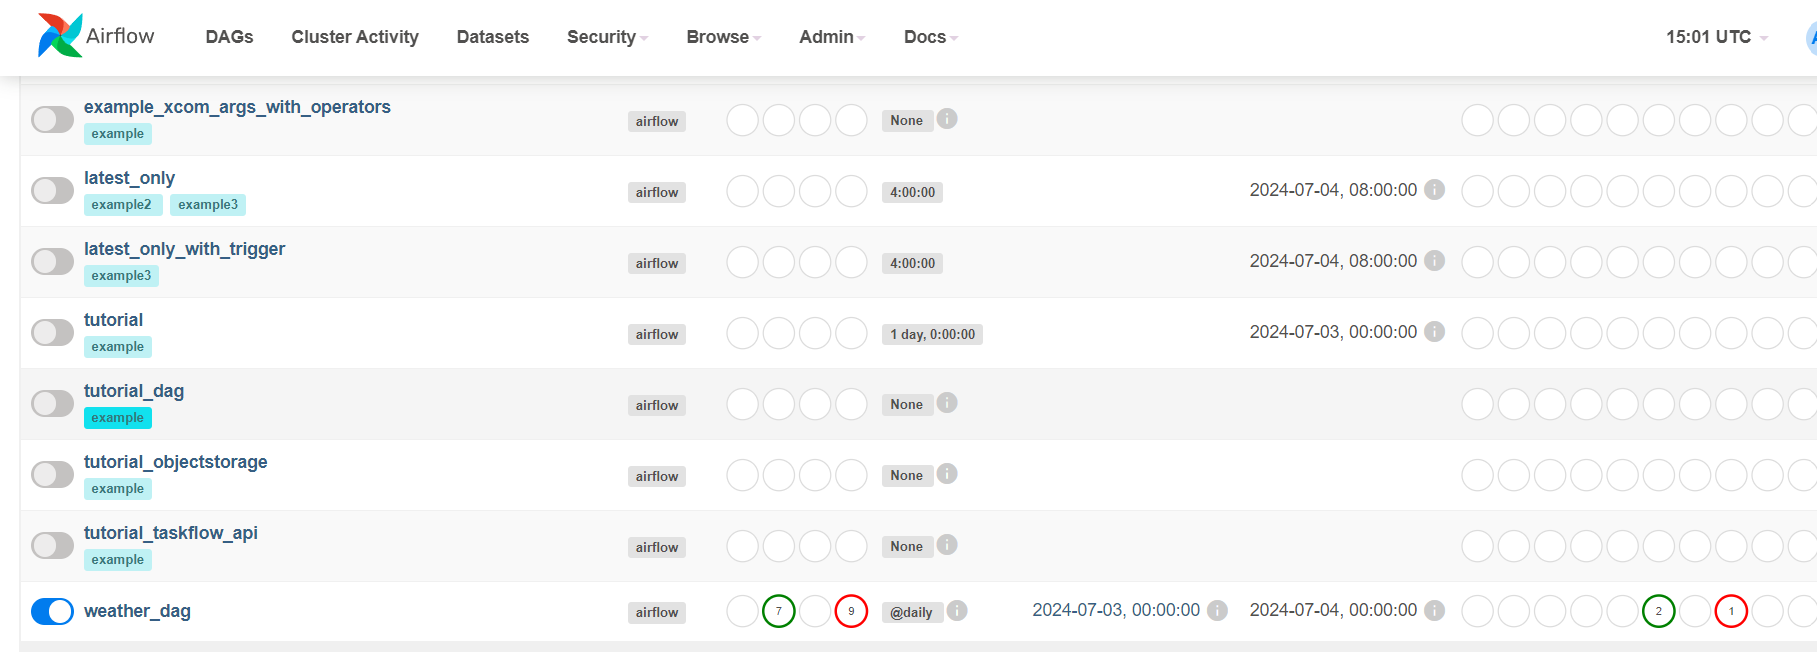

In [9]:
# Weahter dag en Apache Airflow
Image(filename='Cue_Weath_Airflow_2.png', width=1000) 

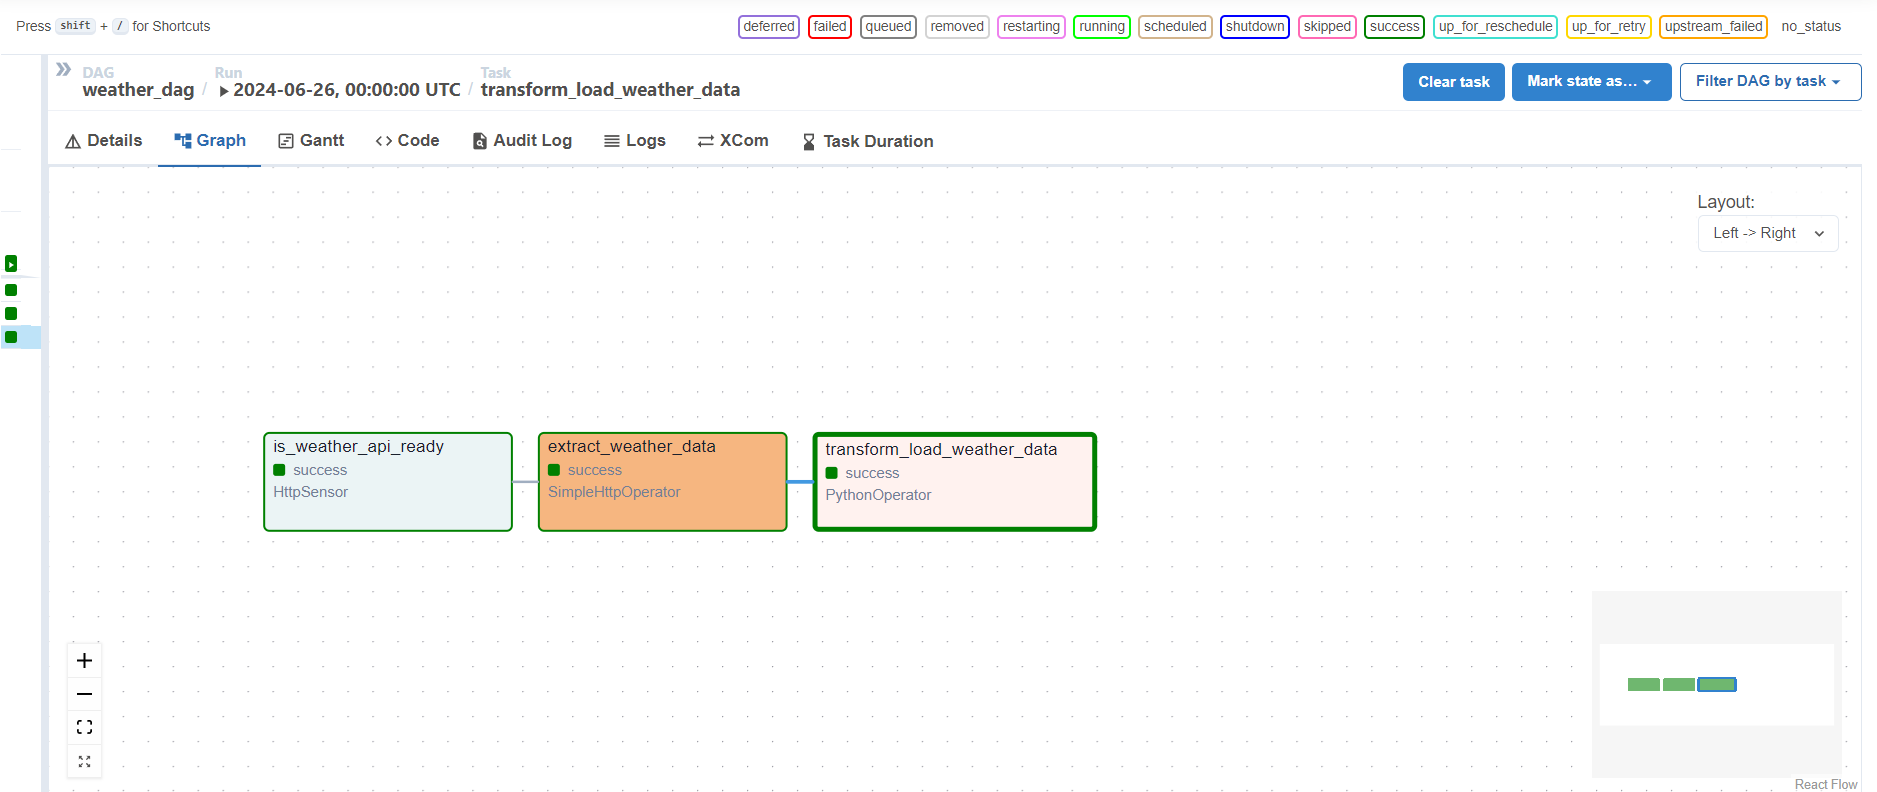

In [11]:
# Porceso ETL exitoso (todos los procesos estan marcados como exitosos en color verde) en Apache Airflow
Image(filename='Cue_Weat_Airflow_1.png', width=2000) 

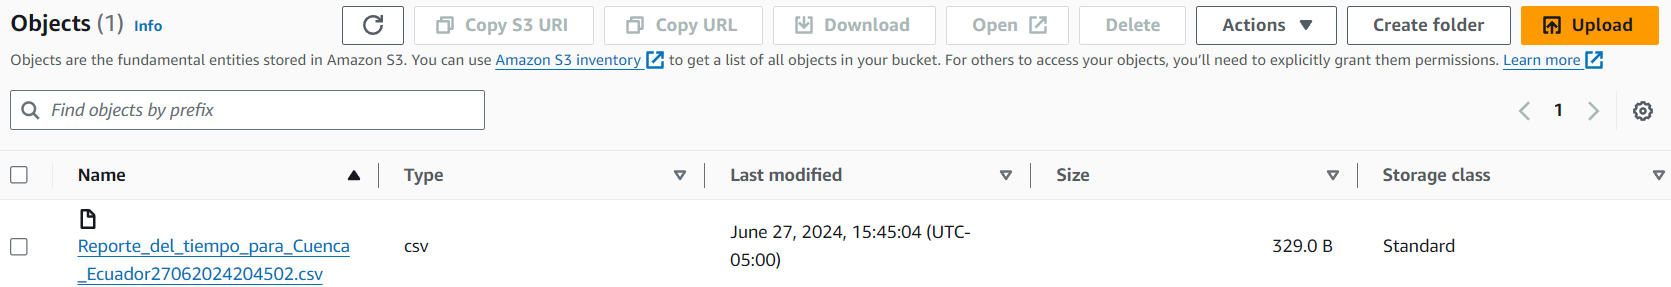

In [13]:
# Diferentes buquets en mi cuenta de aws donde se puede observar el buquet llamado 'cuenca-etl'
Image(filename='cuenta_etl.png', width=2000) 